# Bayesian Logistic Regression using Hamiltonian Monte Carlo (A.K.A. Hybrid Monte Carlo)

This notebook aims to demonstrate on training a Bayesian logistic regression model. The example problem used in the notebook is a binary classification problem. We use Edward (https://github.com/blei-lab/edward) as a Python library to develop the model, since it bases on Tensorflow (https://www.tensorflow.org/) and supports running code on GPU. In particular, the notebook performs the following.

- Create a sample binary-classification dataset that is imbalanced (ratio = 1:9)
- Split the dataset into training and test sets (20% of samples for the test set)
- Define the Bayesian logistic regression model using edward. 
    - We assume Gaussian priors for all parameters for simplicity
    - For Bayesian inference, we use Empirical distribution for the posterior
- Running the inference using edward by feeding the data and estimate the posterior
- Using the model to evaluate on samples by visualizing distribution of predicted probabilities
- Using the model to evaluate the overall binary-classification metrics

In [1]:
#!/usr/bin/env python
"""Bayesian logistic regression using Hamiltonian Monte Carlo.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pandas as pd
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import tensorflow as tf
%matplotlib inline  
from edward.models import Bernoulli, Normal, Empirical

Define default GPU device

In [2]:
DEFAULT_GPU_DEVICE = "/gpu:0"

In [3]:
num_features = 60  # number of features
num_samples =  10000 # number of samples

from sklearn.datasets import make_classification
X_gen, Y_gen = make_classification(n_samples=num_samples, n_features=num_features,
                                    n_informative=10, n_redundant=50,
                                    random_state=42, weights={0:1.8, 1:1})

Look at the distribution of artificially created dataset

In [4]:
np.bincount(Y_gen)

array([8980, 1020])

Convert data to using float representation (required by current version of edward)

In [5]:
X_data = pd.DataFrame(X_gen.astype('float32'))
Y_data = pd.DataFrame(Y_gen.astype('float32'))

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.20,
                                                    random_state=42)

In [7]:
type(X_train)

pandas.core.frame.DataFrame

In [8]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

N = X_train.shape[0]
N

(8000, 60)
(8000, 1)
(2000, 60)
(2000, 1)


8000

# Model definition 

Define logistic regression function 

In [9]:
def logits_func(X, w, b):
  h = ed.dot(X, w) + b
  return tf.reshape(h, [-1])

Bayesian Logistic Regression Model

In [10]:
X = tf.placeholder(tf.float32, [N, num_features])
w = Normal(loc=tf.zeros(num_features, dtype=tf.float32),  scale=3.0 * tf.ones(num_features, dtype=tf.float32))
b = Normal(loc=tf.zeros([], dtype=tf.float32), scale=3.0 * tf.ones([], dtype=tf.float32))
y = Bernoulli(logits=tf.reshape(logits_func(X, w, b), [N, 1]), dtype=tf.float32)

In [11]:
y.shape

TensorShape([Dimension(8000), Dimension(1)])

Inference definition

In [12]:
T = 5000  # number of samples to sample for the empirical distribution
qw = Empirical(params=tf.Variable(tf.random_normal([T, num_features], dtype=tf.float32)))
qb = Empirical(params=tf.Variable(tf.random_normal([T], dtype=tf.float32)))

Verify that the prior and posterior estimation are of the same shapes

In [13]:
print(w.shape)
print(qw.shape)

(60,)
(60,)


In [14]:
print(b.shape)
print(qb.shape)

()
()


# Execute the inferences (Training on the training set)

In [15]:
hmc_inference = ed.HMC({w: qw, b: qb}, data={X: X_train.values, y: Y_train.values})
hmc_inference.initialize(n_print=10, step_size=0.0005)

In [16]:
tf.global_variables_initializer().run()

In [17]:
for t in range(hmc_inference.n_iter):
  info_dict = hmc_inference.update()
  hmc_inference.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 21s | Acceptance Rate: 1.000


Evaluatation code for a single sample

In [47]:
def eval_at_sample(index):
    """
    Evaluate a single sample of a test set 
    :param index: index of the sample for testing
    :return:
    """
    print(" Real value is %s" % Y_test.iloc[index, 0])
    # Build samples from inferred posterior.
    num_samples = 100
    probs = tf.concat([tf.sigmoid(
             logits_func(X_test.iloc[index,:].values.reshape([1, num_features]), 
                                              qw.sample(), qb.sample()
                                             ))
                      for _ in range(num_samples)], axis=0)
    pd.DataFrame(probs.eval()).plot(kind="density", legend=False)
    plt.xlabel("Bayesian Predicted Probability")

# How does the predicted distribution of probability look like for class = 0?

 Real value is 0.0


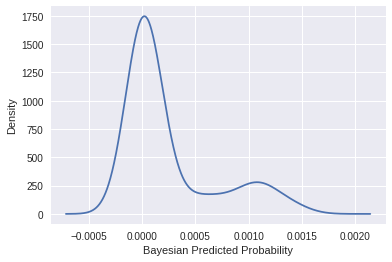

In [48]:
eval_at_sample(0)

 Real value is 0.0


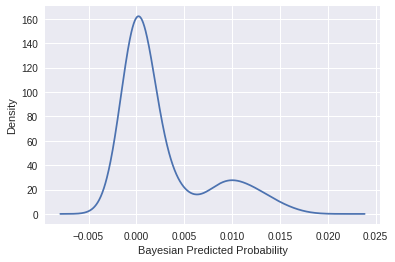

In [49]:
eval_at_sample(2)

 Real value is 0.0


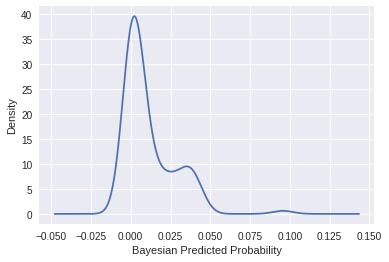

In [50]:
eval_at_sample(3)

 Real value is 0.0


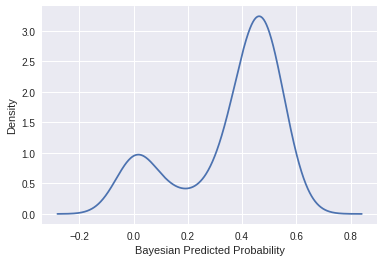

In [51]:
eval_at_sample(5)

 Real value is 0.0


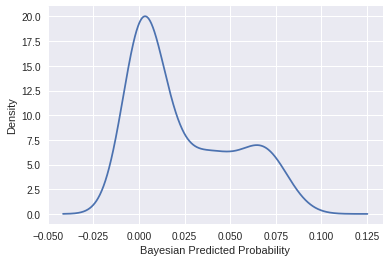

In [52]:
eval_at_sample(7)

 Real value is 0.0


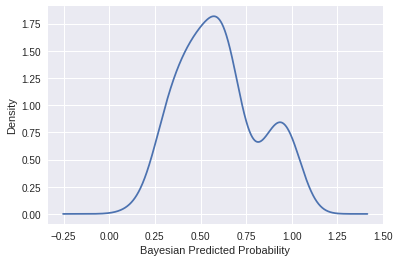

In [53]:
eval_at_sample(10)

It looks quite promising, since most of the negative samples low probability in the predictions

# How does the predicted distribution of probability look like for class = 1?

 Real value is 1.0


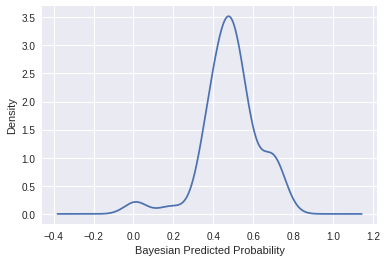

In [54]:
eval_at_sample(9)

 Real value is 1.0


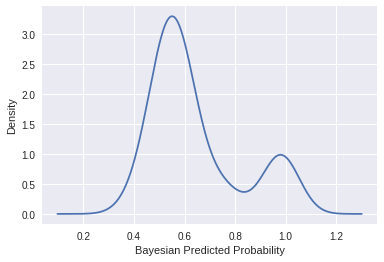

In [55]:
eval_at_sample(23)

 Real value is 1.0


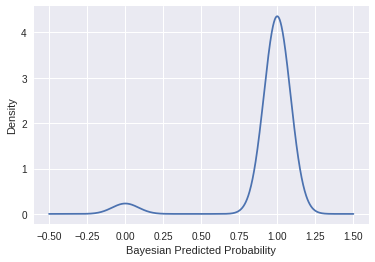

In [56]:
eval_at_sample(1995)

 Real value is 1.0


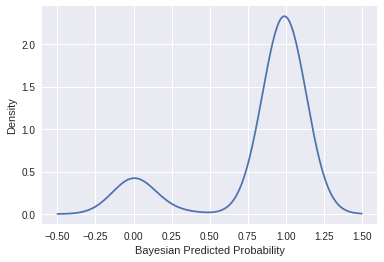

In [57]:
eval_at_sample(1623)

 Real value is 1.0


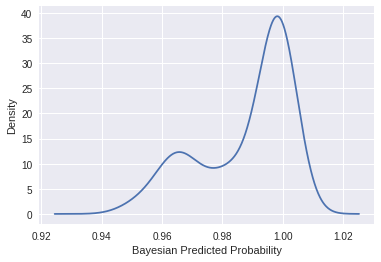

In [58]:
eval_at_sample(1632)

 Real value is 1.0


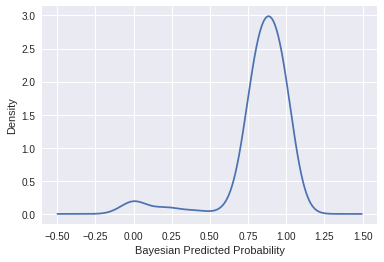

In [59]:
eval_at_sample(1804)

Most of the positive samples have high probability in the predictions

# What about overall evaluation results?

We adopt minibatch prediction here to speed up the computation

In [60]:
from sklearn import metrics

In [61]:
batch_size = 5

Setup a specific threshold for detection, you can adjust here to have a tradeoff between precision and recall

In [62]:
selected_percentile = 30
selected_threshold  =  0.8

In [63]:
def probs_tensor_at_sample(X_row):
    """
    Compute a probability distribution of a single sample (by sampling from posterior distribution)
    :param X_row: input data of a single observation
    :return: 1-D tensor of shape [1, num_predict_samples] that are sampled from the distribution
    """
    num_predict_samples = 100
    return tf.concat([
        tf.sigmoid(logits_func(X_row, qw.sample(), qb.sample())) 
        for _ in range(num_predict_samples)], axis=0)

In [64]:
def probs_tensor_batch(X_rows_pl):
    """
    Compute a batch of posterior probability distribution of a batch of samples    
    :param X_rows_pl: a batch of input data (Tensorflow placeholder)
    :return: 2-D tensor of shape [batch_size, num_predict_samples]
    """
    return tf.stack([
                      probs_tensor_at_sample(
                          tf.reshape(X_rows_pl[i,:], [1, num_features]))
                      for i in range(X_rows_pl.shape[0])])

Use the GPU device here in order to speedup the computation

In [65]:
with tf.device(DEFAULT_GPU_DEVICE):
    X_rows_pl = tf.placeholder(tf.float32, [batch_size, num_features])
    tf_graph = probs_tensor_batch(X_rows_pl)

In [66]:
def prediction_decision_function(probs_output):
    """
    Compute a prediction decision for a particular sample from the distribution of probabilities    
    :param probs_output: 1-D tensor of shape [1, num_predict_samples] that are sampled from the distribution
    :return: 2-D tensor of shape [batch_size, num_predict_samples]
    """
    if np.percentile(probs_output, selected_percentile) >= selected_threshold:
        return 1.0
    else:
        return 0.0
    

In [67]:
def eval_predict_at_batch(batch_offset, X, Y):
    """ 
    Evaluation of prediction results of a single batch
    :param batch_offset: the integer indicating the offset from the full data
    :param X: the full input data
    :param Y: the full output data
    :return 
    """
    X_rows =  X.iloc[batch_offset:(batch_offset + batch_size), :].values
    Y_rows =  Y.iloc[batch_offset:(batch_offset + batch_size)].values
    probs_batch_out = tf_graph.eval(feed_dict={X_rows_pl: X_rows})
    predict_batch_output = []
    predict_batch_percentiles = []
    for i in range(probs_batch_out.shape[0]):
        predict_batch_percentiles += [np.percentile(probs_batch_out[i], selected_percentile)]        
        predict_batch_output += [prediction_decision_function(
                                probs_batch_out[i])]
    return predict_batch_output, predict_batch_percentiles

In [68]:
def get_classification_results_text(Y_actual, Y_prediction):
    """
    Produce classification results in textual format
    :param 1-D array of actual output
    :param 1-D array of predictions
    :return Textual representation of the classification results
    """
    
    string_output = ""
    string_output += "accuracy = %.2f, precision = %.2f, recall = %.2f, F1-score = %.2f \n" % (
            metrics.accuracy_score(Y_actual, Y_prediction),
            metrics.precision_score(Y_actual, Y_prediction),
            metrics.recall_score(Y_actual, Y_prediction),
            metrics.f1_score(Y_actual, Y_prediction)
        )
    
    string_output += (" ---------- Confusion Matrix ------------\n")
    string_output += str(metrics.confusion_matrix(Y_actual, Y_prediction)) + "\n"
    string_output += (" ----------------------------------------\n")
    return string_output

In [69]:
def eval_classification_on_indexes(input_indexes, X, Y):
    """
    Evaluate classification results at particular sample indexes
    :param input_indexes: integer indexes of samples to evaluate on
    :param X: full input data
    :param Y: full output data
    """
    num_batches  = len(input_indexes) // batch_size
    indexes      = input_indexes[:(num_batches * batch_size)]
    X_on_indexes = X.loc[indexes, :]
    Y_on_indexes = Y.loc[indexes]
    Y_predictions = []
    selected_percentiles = []
    
    for batch_index in range(num_batches):
        batch_offset = batch_index * batch_size
        batch_predictions, batch_percentiles = eval_predict_at_batch(batch_offset, X_on_indexes, Y_on_indexes)
        Y_predictions += batch_predictions
        selected_percentiles += batch_percentiles
           
    return get_classification_results_text(Y_on_indexes, Y_predictions), selected_percentiles

In [70]:
def eval_classification_on_main(num_eval_samples, X, Y, Y_values_in=[0.0, 1.0]):    
    """
    Evaluate classification results according to number of samples and valued of output
    :param num_eval_samples: number of samples to evaluate
    :param X: full input data
    :param Y: full output data
    :param Y_values_in: list of possible Y values to include in the evaluation
    """
    selected_indexes = Y[Y.apply(lambda x: x[0] in Y_values_in, axis=1)].sample(num_eval_samples).index
    result_text, selected_percentiles = eval_classification_on_indexes(selected_indexes, 
                                           X, 
                                           Y)
    print(" -------- Classification Summary -------------")
    print(result_text)

In [71]:
def eval_classification_on_indexes_test(num_eval_samples, Y_values_in=[0.0, 1.0]):
    """
    Evaluation on test dataset according to specified number of samples
    :param num_eval_samples: number of samples to evaluate
    :param Y_values_in: list of possible Y values to include in the evaluation
    """
    eval_classification_on_main(num_eval_samples, X_test,  Y_test,  Y_values_in)

def eval_classification_on_indexes_train(num_eval_samples, Y_values_in=[0.0, 1.0]):
    """
    Evaluation on training dataset according to specified number of samples
    :param num_eval_samples: number of samples to evaluate
    :param Y_values_in: list of possible Y values to include in the evaluation
    """
    eval_classification_on_main(num_eval_samples, X_train, Y_train, Y_values_in)



In [72]:
eval_classification_on_indexes_train(500)

 -------- Classification Summary -------------
accuracy = 0.95, precision = 0.86, recall = 0.62, F1-score = 0.72 
 ---------- Confusion Matrix ------------
[[447   5]
 [ 18  30]]
 ----------------------------------------



In [73]:
eval_classification_on_indexes_test(500)

 -------- Classification Summary -------------
accuracy = 0.94, precision = 0.79, recall = 0.50, F1-score = 0.61 
 ---------- Confusion Matrix ------------
[[450   6]
 [ 22  22]]
 ----------------------------------------



In [74]:
eval_classification_on_indexes_test(2000)

 -------- Classification Summary -------------
accuracy = 0.95, precision = 0.86, recall = 0.62, F1-score = 0.72 
 ---------- Confusion Matrix ------------
[[1766   21]
 [  82  131]]
 ----------------------------------------

